###  All plots were plotted using plotly. Github doesn't support interactive plotly so saved 'svg' format images

In [96]:
import pandas as pd
import numpy as np
import folium
import geopandas
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
from random import uniform as uni
import plotly.graph_objects as go
import plotly.express as px
from plotly.graph_objs import Data as Data
from geopy.geocoders import Nominatim
import re
from warnings import filterwarnings
filterwarnings('ignore')

In [97]:
df = pd.read_csv('data.csv')
df.head(3)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26


In [98]:
df.replace('NaN ',np.nan,inplace=True)

In [99]:
null_rows = df[df.isnull().any(axis=1)]
df.drop(null_rows.index,axis=0,inplace=True)

In [100]:
df['Delivery_person_Age'] = df['Delivery_person_Age'].apply(lambda x:int(x))
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].apply(lambda x:float(x))

In [101]:
df.drop(df[(df.Restaurant_latitude==0) | (df.Restaurant_longitude==0) | (df.Delivery_location_longitude==0) | (df.Delivery_location_latitude==0)].index,inplace=True)

In [102]:
def get_distance(r_lat,r_long,d_lat,d_long):
    start_location = [r_lat,r_long]
    end_location = [d_lat,d_long]
    route = distance.distance(start_location, end_location).km
    return round(route,2)

In [103]:
df['distance'] = df[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude','Delivery_location_longitude']].apply(lambda x: get_distance(*x), axis=1)

In [104]:
df.drop(df[df.distance>50].index,inplace=True)

In [105]:
def get_city_intials(string):
    match = re.search(r"(.*)RES", string)
    if match:
        before_res = match.group(1)
        return before_res

In [106]:
df['City_Initials'] = df['Delivery_person_ID'].apply(get_city_intials)

In [107]:
df['City_Name'] = df['City_Initials'].map({'INDO':'Indore','BANG':'Bangalore','COIMB':'Coimbatore','CHEN':'Chennai',
                                      'HYD':'Hydrabad','RANCHI':'Ranchi','MYS':'Mysore','DEH':'Delhi',
                                      'KOC':'Kochi','PUNE':'Pune','LUDH':'Ludhiana','KNP':'Kanpur','MUM':'Mumbai',
                                      'KOL':'Kolkata','JAP':'Jaipur','SUR':'Surat','GOA':'Goa','AURG':'Aurangabad',
                                      'AGR':'Agra','VAD':'Vadodara','ALH':'Prayagraj','BHP':'Bhopal'})

In [108]:
Orders_by_City_dict = df.groupby(['City_Name']).ID.count()
Orders_by_City = pd.DataFrame(columns=['City_Name','Orders'])
Orders_by_City['City_Name'] = Orders_by_City_dict.keys()
Orders_by_City['Orders'] = Orders_by_City_dict.values

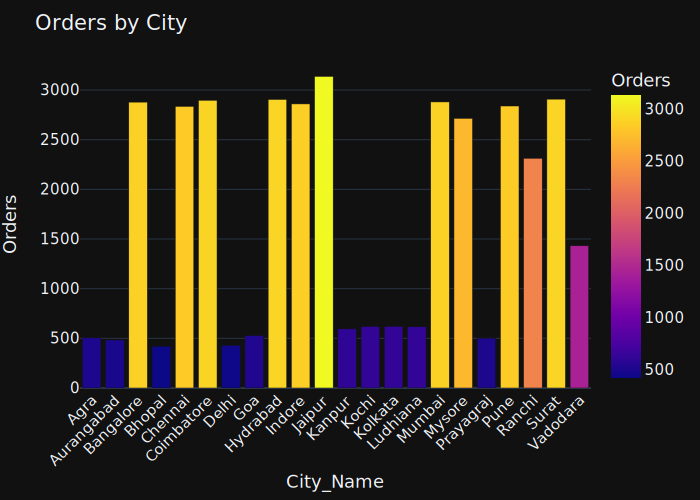

In [109]:
fig = px.bar(data_frame=Orders_by_City,x='City_Name',y='Orders',color='Orders')
fig.layout.template = "plotly_dark"
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(title='Orders by City')
fig.show('svg')

In [110]:
def get_lat(city):
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.geocode(city)
    return location.raw['lat']

Orders_by_City['Latitude'] = Orders_by_City.City_Name.apply(get_lat)

In [111]:
def get_long(city):
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.geocode(city)
    return location.raw['lon']

Orders_by_City['Longitude'] = Orders_by_City.City_Name.apply(get_long)

In [112]:
Orders_by_City.loc[Orders_by_City['City_Name']=='Surat','Latitude']=21.170240
Orders_by_City.loc[Orders_by_City['City_Name']=='Surat','Longitude']=72.831062
Orders_by_City.loc[Orders_by_City['City_Name']=='Hydrabad','Latitude']=17.3850
Orders_by_City.loc[Orders_by_City['City_Name']=='Hydrabad','Longitude']=78.4867

In [113]:
from folium.plugins import MarkerCluster

center_coords = [20.5937, 78.9629]
m = folium.Map(location=center_coords, zoom_start=4)

marker_cluster = MarkerCluster().add_to(m)

data = Orders_by_City

for i in range(len(data)):
    folium.Marker(
        location=[data.iloc[i]['Latitude'], data.iloc[i]['Longitude']],
        popup=data.iloc[i]['City_Name'] + '<br>' + 'Orders: ' + str(data.iloc[i]['Orders']),
        icon=folium.Icon(color='red')
    ).add_to(marker_cluster)

folium.LayerControl().add_to(m)

m

In [114]:
# Create the base map
m = folium.Map(location=center_coords, zoom_start=4)

# Create a dataframe with city names, orders, lon and lat

# Create the heatmap layer
heatmap = folium.plugins.HeatMap(
    data=data[['Latitude', 'Longitude', 'Orders']].values.tolist(),
    name='Orders per City',
    min_opacity=0.2,
    overlay=True,
    control=False
)
heatmap.add_to(m)

# Add a layer control to switch between different layers
folium.LayerControl().add_to(m)

# Display the map
m


In [115]:
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance,City_Initials,City_Name
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,...,2,Snack,motorcycle,0,No,Urban,(min) 24,3.02,INDO,Indore
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,...,2,Snack,scooter,1,No,Metropolitian,(min) 33,20.14,BANG,Bangalore
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,...,0,Drinks,motorcycle,1,No,Urban,(min) 26,1.55,BANG,Bangalore
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,...,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21,7.77,COIMB,Coimbatore
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,...,1,Snack,scooter,1,No,Metropolitian,(min) 30,6.20,CHEN,Chennai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45587,0x1178,RANCHIRES16DEL01,35,4.2,23.371292,85.327872,23.481292,85.437872,08-03-2022,21:45:00,...,2,Drinks,motorcycle,1,No,Metropolitian,(min) 33,16.58,RANCHI,Ranchi
45588,0x7c09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,24-03-2022,11:35:00,...,1,Meal,motorcycle,0,No,Metropolitian,(min) 32,1.49,JAP,Jaipur
45590,0x4f8d,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,11-03-2022,23:50:00,...,1,Drinks,scooter,0,No,Metropolitian,(min) 16,4.65,CHEN,Chennai
45591,0x5eee,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,07-03-2022,13:35:00,...,0,Snack,motorcycle,1,No,Metropolitian,(min) 26,6.22,COIMB,Coimbatore


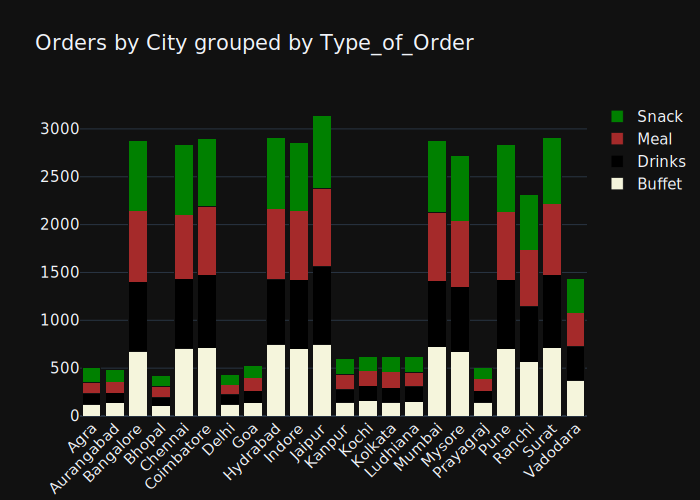

In [116]:
import plotly.graph_objs as go
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['City_Name', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['City_Name'], y=ot_df['counts'], name=ot, 
                  marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')
fig = go.Figure(data=data, layout=layout)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(title='Orders by City grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show('svg')

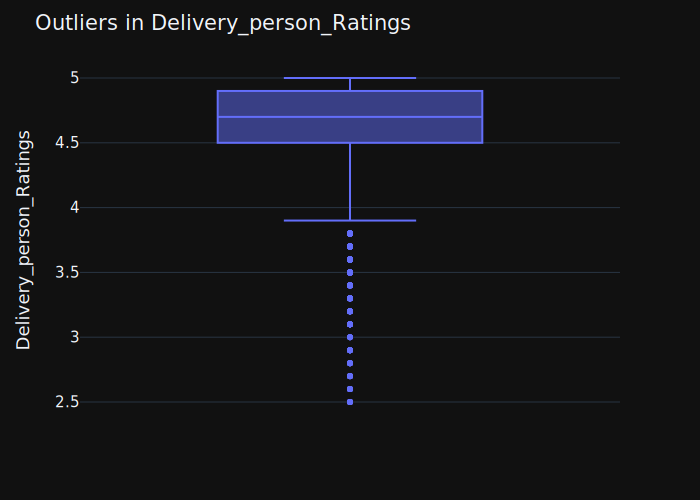

In [117]:
fig = px.box(df, y="Delivery_person_Ratings")
fig.layout.template = "plotly_dark"
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(title='Outliers in Delivery_person_Ratings')
fig.show('svg')

In [118]:
# Dropping ">5" Rating samples
df.drop(df[df.Delivery_person_Ratings>5].index,inplace=True)

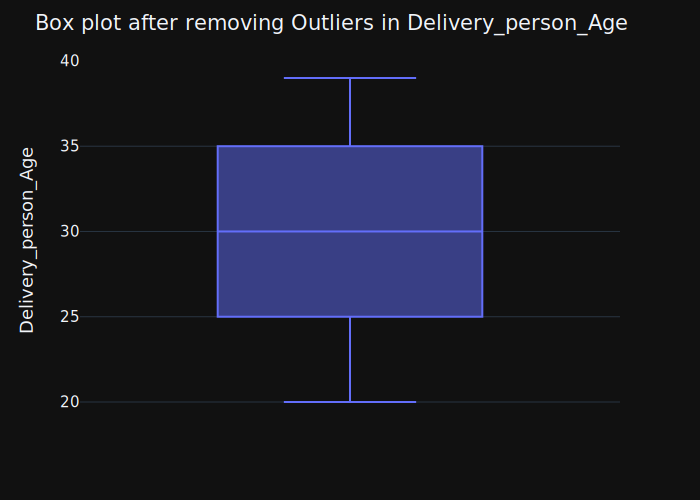

In [119]:
fig = px.box(df, y="Delivery_person_Age")
fig.layout.template = "plotly_dark"
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(title='Box plot after removing Outliers in Delivery_person_Age')
fig.show('svg')

In [120]:
# Keeping the Legal Age only:
df.drop(df[df.Delivery_person_Age<18].index,inplace=True)

In [121]:
def get_time(string):
    match = re.search(r"\(\w+\) (\d+)", string)
    if match:
        return int(match.group(1))
df['Time_taken(min)'] = df['Time_taken(min)'].apply(get_time)

In [122]:
df['Delivery_person_Age'] = df['Delivery_person_Age'].apply(lambda x:int(x))
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].apply(lambda x:float(x))

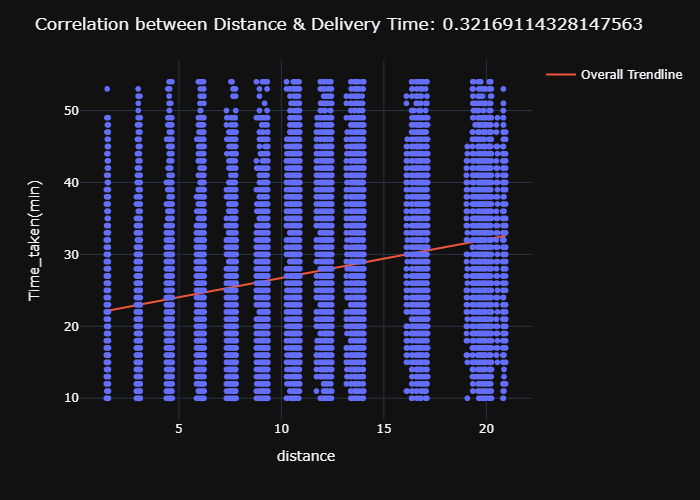

In [145]:
correlation = df['distance'].corr(df['Time_taken(min)'])
fig = px.scatter(df,x='distance',y='Time_taken(min)',trendline="ols",trendline_scope='overall')
fig.update_layout(title=f"Correlation between Distance & Delivery Time: {correlation}")
fig.layout.template = "plotly_dark"
fig.show('png')

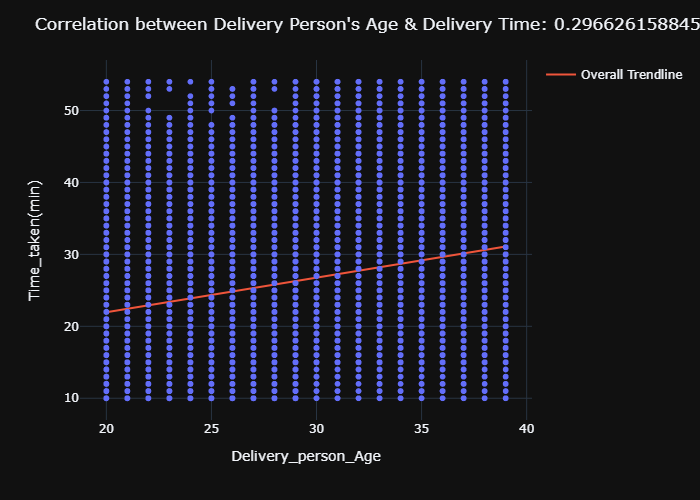

In [146]:
correlation = df['Delivery_person_Age'].corr(df['Time_taken(min)'])
fig = px.scatter(df,x='Delivery_person_Age',y='Time_taken(min)',trendline="ols",trendline_scope='overall')
fig.update_layout(title=f"Correlation between Delivery Person's Age & Delivery Time: {correlation}")
fig.layout.template = "plotly_dark"
fig.show('png')

In [125]:
def age_bucket(age):
    if age<25:
        return 1
    elif age<30:
        return 2
    elif age<35:
        return 3
    else:
        return 4

df['Age_Bucket'] = df['Delivery_person_Age'].apply(age_bucket)

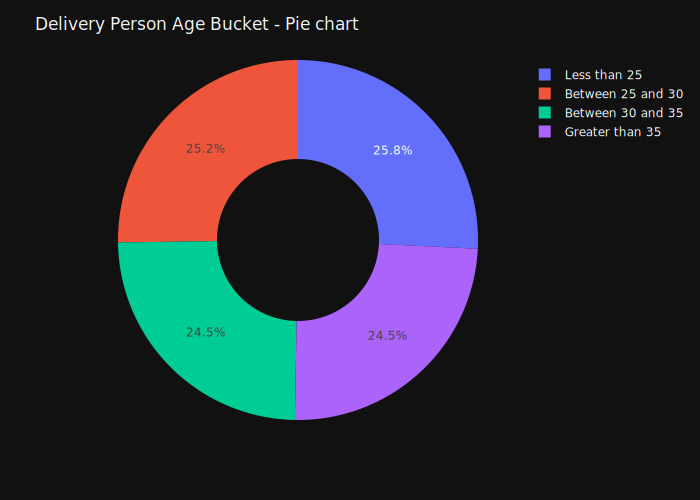

In [126]:
AgeBuckets = ['Less than 25','Between 25 and 30','Between 30 and 35','Greater than 35']
age_bucket_dict = df.Age_Bucket.value_counts().to_dict()
age_bucket_dict = dict(zip(AgeBuckets, list(age_bucket_dict.values())))
fig = px.pie(names=age_bucket_dict.keys(),values=age_bucket_dict.values(),hole=0.45)
fig.update_layout(title="Delivery Person Age Bucket - Pie chart")
fig.layout.template = "plotly_dark"
fig.show('svg')

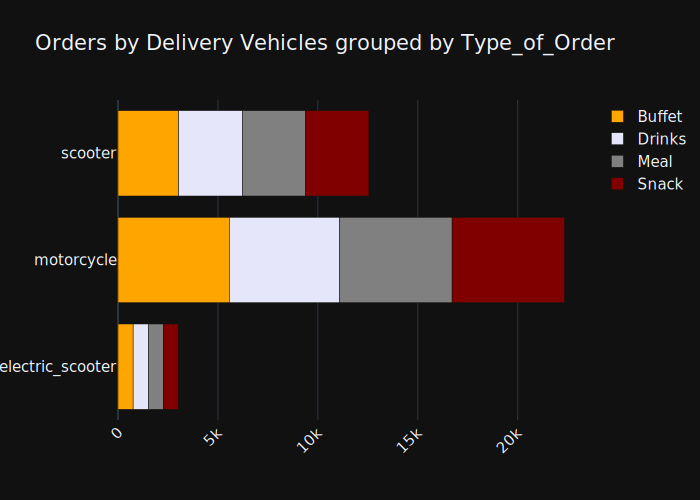

In [144]:
import plotly.graph_objs as go
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Type_of_vehicle', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Type_of_vehicle'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Delivery Vehicles grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show('svg')

In [128]:
def get_condition(text):
    match = re.search("conditions (.*)", text)

    if match:
        conditions = match.group(1)
        return conditions

In [129]:
df['Weatherconditions'] = df['Weatherconditions'].apply(get_condition)


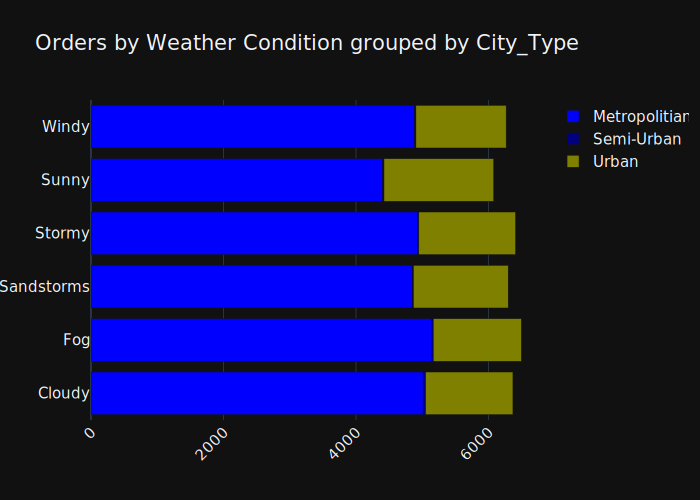

In [130]:
import plotly.graph_objs as go
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['City'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Weatherconditions', 'City']).size().reset_index(name='counts')

data = []
for ot in df_grouped['City'].unique():
    ot_df = df_grouped[df_grouped['City'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Weatherconditions'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Weather Condition grouped by City_Type')
fig.layout.template = "plotly_dark"
fig.show('svg')

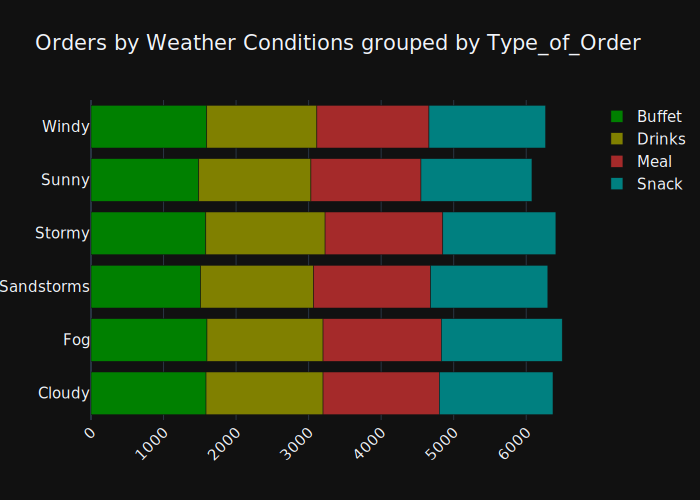

In [131]:
import plotly.graph_objs as go
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Weatherconditions', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Weatherconditions'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Weather Conditions grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show('svg')

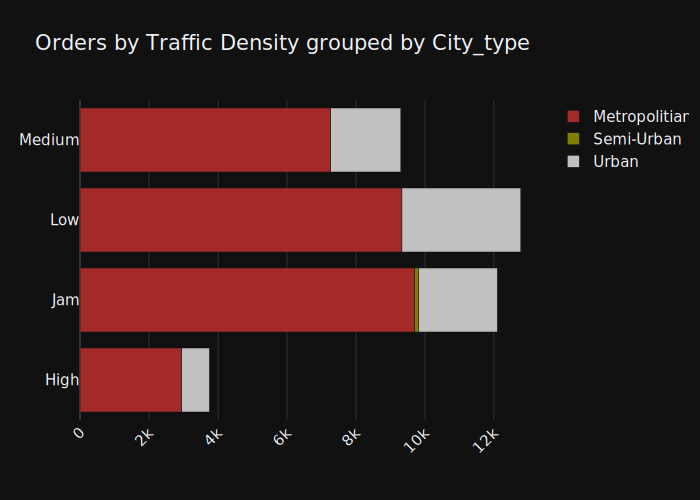

In [132]:
import plotly.graph_objs as go
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['City'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Road_traffic_density', 'City']).size().reset_index(name='counts')

data = []
for ot in df_grouped['City'].unique():
    ot_df = df_grouped[df_grouped['City'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Road_traffic_density'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Traffic Density grouped by City_type')
fig.layout.template = "plotly_dark"
fig.show('svg')

In [133]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'],format='%d-%m-%Y')

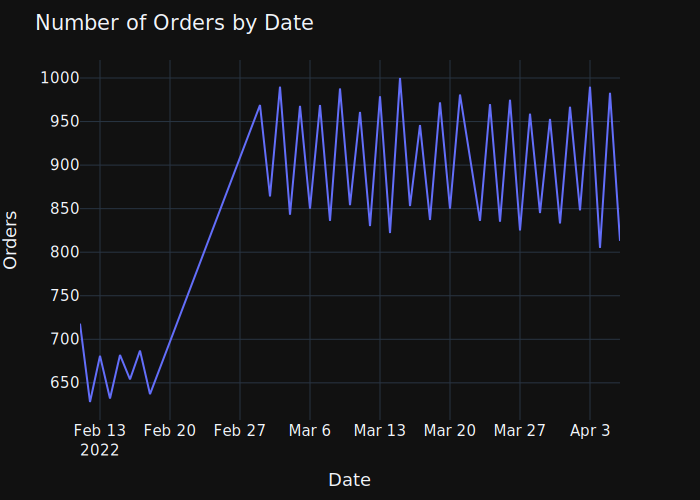

In [134]:
Orders_per_day = df.groupby(['Order_Date']).ID.count().to_dict()
Orders_by_Date = pd.DataFrame(columns=['Date','Orders'])
Orders_by_Date['Date'] = Orders_per_day.keys()
Orders_by_Date['Orders'] = Orders_per_day.values()
fig = px.line(Orders_by_Date,x='Date',y='Orders')
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(title='Number of Orders by Date')
fig.layout.template = "plotly_dark"
fig.show('svg')

In [135]:
def bucket_time(time):
    hours = time.hour
    if hours < 4:
        return '0-4'
    elif hours < 8:
        return '4-8'
    elif hours < 12:
        return '8-12'
    elif hours < 16:
        return '12-16'
    elif hours < 20:
        return '16-20'
    else:
        return '20-24'

df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd']).dt.time
df['interval'] = df['Time_Orderd'].apply(bucket_time)

In [136]:
Orders_per_time = df.interval.value_counts().to_dict()
Orders_by_interval = pd.DataFrame(columns=['Time','Orders'])
Orders_by_interval['Time'] = Orders_per_time.keys()
Orders_by_interval['Orders'] = Orders_per_time.values()

### Script taken from open-source.
def rose_chart1(df):
    traces = []
    df_ = df.pivot(columns = "Time",values="Orders")
    for ind,meta in df_.iterrows():
        trace = {
              "name": meta.index[ind], 
              "r": meta.values, 
              "type": "barpolar", 
              "opacity": 1, 
              "theta": df_.columns.values, 
              "hoverinfo": "r+theta",
              "opacity" : 0.68
              }
        traces.append(trace)
    layout = {
      "font": {
        "size": 16, 
        "family": "Overpass"
      }, 
      "polar": {
        "hole": 0.0, 
        "bargap": 0.05,  
        "radialaxis": {
          "visible":True,
          "type": "linear", 
          "title": {"text": "<br>"}, 
          "tickmode": "auto", 
          "tickfont": {"size": 14}, 
          "autorange": True, 
          "gridwidth": 2,
          "linewidth": 0
        }, 
        "angularaxis": {
          "type": "category", 
          "ticklen": 12, 
          "tickmode":"auto",
          "tickfont": {"color": "rgb(22, 22, 22)"}, 
          "direction": "counterclockwise", 
          "gridwidth": 2, 
          "tickwidth": 1, 
          "tickprefix": ""
        }
      }, 
      "title": {"text": "Rose chart for Orders per Time Bucket"}, 
      "xaxis": {
        "range": [-1, 6], 
        "autorange": True
      }, 
      "yaxis": {
        "range": [-1, 4], 
        "autorange": True
      }, 
      "legend": {
        "x": 1, 
        "y": 1, 
        "font": {
          "size": 14, 
          "family": "Roboto"
        }, 
        "title": {
          "font": {
            "size": 16, 
            "color": "rgb(67, 36, 167)", 
            "family": "Overpass"
          }, 
          "text": "Time Buckets"
        }, 
        "xanchor": "auto", 
        "itemsizing": "trace", 
        "traceorder": "normal", 
        "borderwidth": 0, 
        "orientation": "v"
      }, 
      "modebar": {
        "color": "rgba(68, 68, 68, 0.3)", 
        "bgcolor": "rgba(118, 6, 6, 0.5)", 
        "orientation": "h"
      }, 
      "autosize": True, 
      "template": {
        "data": {
          "bar": [
            {
              "type": "bar", 
              "marker": {"colorbar": {
                  "len": 0.2, 
                  "ticks": "inside", 
                  "ticklen": 6, 
                  "tickcolor": "rgb(237,237,237)", 
                  "outlinewidth": 0
                }}
            }
          ], 
          "carpet": [
            {
              "type": "carpet", 
              "aaxis": {
                "gridcolor": "white", 
                "linecolor": "white", 
                "endlinecolor": "rgb(51,51,51)", 
                "minorgridcolor": "white", 
                "startlinecolor": "rgb(51,51,51)"
              }, 
              "baxis": {
                "gridcolor": "white", 
                "linecolor": "white", 
                "endlinecolor": "rgb(51,51,51)", 
                "minorgridcolor": "white", 
                "startlinecolor": "rgb(51,51,51)"
              }
            }
          ], 
        }, 
        "layout": {
          "geo": {
            "bgcolor": "white", 
            "showland": True, 
            "lakecolor": "white", 
            "landcolor": "rgb(237,237,237)", 
            "showlakes": True, 
            "subunitcolor": "white"
          }, 
          "font": {"color": "rgb(51,51,51)","family": "Overpass"}, 
          "polar": {
            "bgcolor": "rgb(237,237,237)", 
            "angularaxis": {
              "ticks": "outside", 
              "showgrid": True, 
              "gridcolor": "white", 
              "linecolor": "white", 
              "tickcolor": "rgb(51,51,51)"
            },
          },   
          "hovermode": "closest", 
          "plot_bgcolor": "rgb(237,237,237)", 
          "paper_bgcolor": "white", 
          "shapedefaults": {
            "line": {"width": 0}, 
            "opacity": 0.3, 
            "fillcolor": "black"}, 
          "annotationdefaults": {
            "arrowhead": 0, 
            "arrowwidth": 1}
        }
      }, 
      "coloraxis": {"cauto": True}, 
      "separators": ", "
    }    

    data = Data(traces)
    fig = go.Figure(data,layout)
    fig.layout.template = "plotly_dark"
    fig.show('svg')

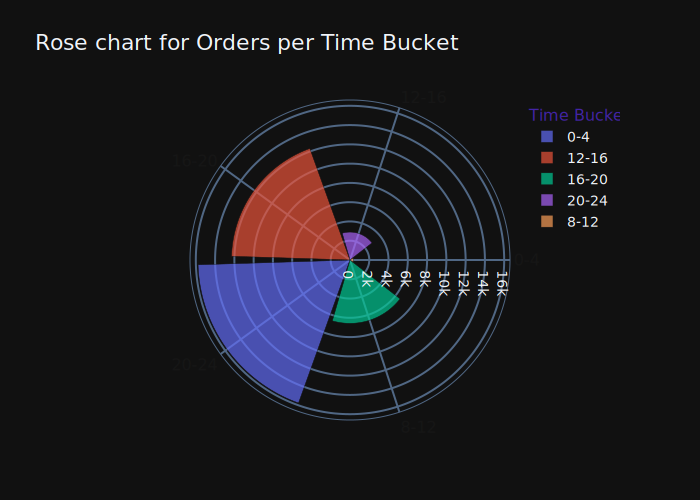

In [137]:
rose_chart1(Orders_by_interval)

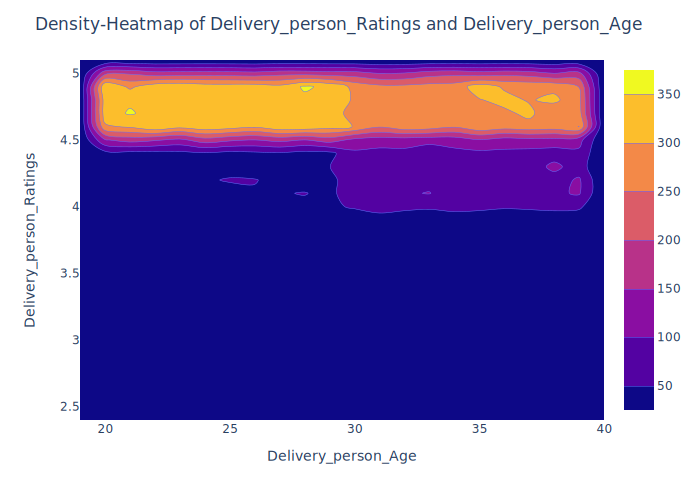

In [138]:
fig = px.density_contour(df,x='Delivery_person_Age',y='Delivery_person_Ratings')
fig.update_traces(contours_coloring="fill")
#fig.layout.template = "plotly_dark"
fig.update_layout(title='Density-Heatmap of Delivery_person_Ratings and Delivery_person_Age')
fig.show('svg')

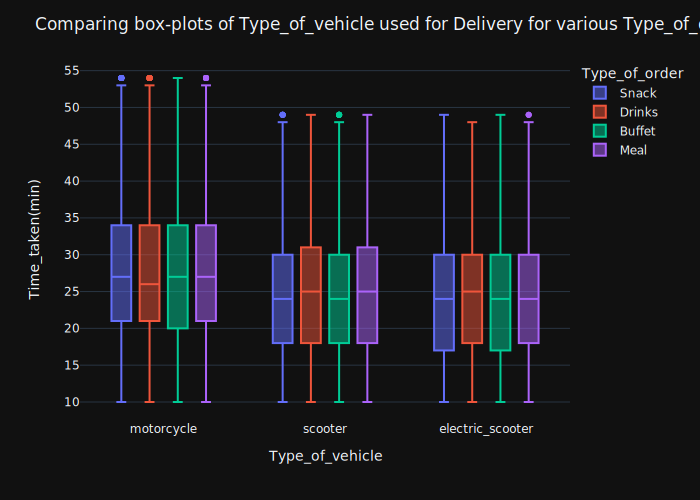

In [139]:
fig = px.box(df, 
             x="Type_of_vehicle",
             y="Time_taken(min)", 
             color="Type_of_order")
fig.layout.template='plotly_dark'
fig.update_layout(title='Comparing box-plots of Type_of_vehicle used for Delivery for various Type_of_order against time')
fig.show('svg')

In [140]:
df['Day'] = pd.to_datetime(df.Order_Date).dt.day_name()

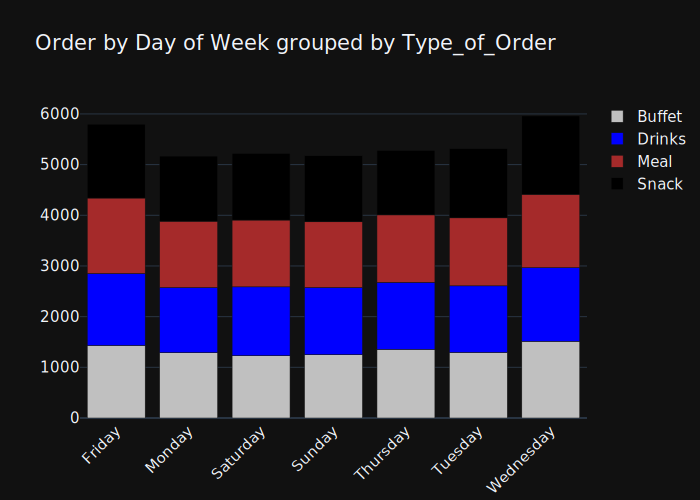

In [141]:
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Day', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['Day'], y=ot_df['counts'], name=ot,orientation='v'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Order by Day of Week grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show('svg')

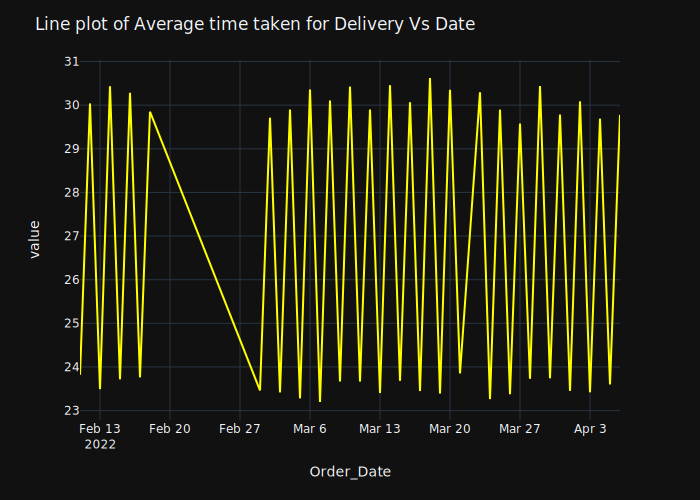

In [142]:
date_df_dict = df.groupby(['Order_Date'])['Time_taken(min)'].mean().to_dict()
date_df = pd.DataFrame(columns=['Order_Date','Avg'])
date_df['Order_Date']=date_df_dict.keys()
date_df['Time_taken(min)']=date_df_dict.values()
date_df.index = date_df['Order_Date']
date_df.drop('Order_Date',axis=1,inplace=True)
fig = px.line(date_df.drop('Avg',axis=1))
fig.update_traces(line_color='yellow')
fig.update_layout(showlegend=False)
fig.update_layout(title='Line plot of Average time taken for Delivery Vs Date')
fig.layout.template = "plotly_dark"
fig.show('svg')

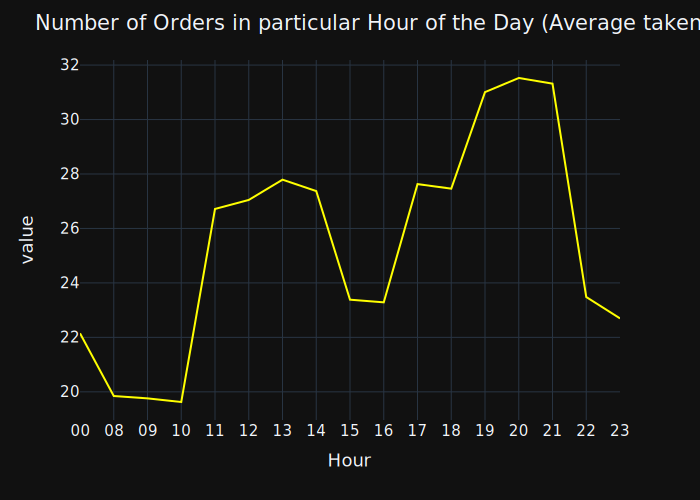

In [143]:
time_df = df[['ID','Time_Orderd','Time_taken(min)']]
time_df['Hour'] = time_df['Time_Orderd'].apply(lambda x: x.strftime('%H'))
time_df_grouped = time_df.groupby('Hour').mean()
fig = px.line(time_df_grouped)
fig.update_traces(line_color='yellow')
fig.update_layout(showlegend=False)
fig.update_layout(title='Number of Orders in particular Hour of the Day (Average taken)')
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.layout.template = "plotly_dark"
fig.show('svg')

In [50]:
df['Hour'] = df['Time_Orderd'].apply(lambda x: x.strftime('%H'))

In [51]:
def outliers(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    
    IQR = Q3-Q1
    
    lower = Q1-1.5*IQR
    upper = Q3+1.5*IQR
    
    ls = df.index [ (df[ft]< lower) | (df[ft] > upper) ]
    
    return ls

In [52]:
Delivery_time_taken_outliers = outliers(df,'Time_taken(min)')
print(f'Outliers in Time_taken(min): {len(Delivery_time_taken_outliers)}')
df.drop(Delivery_time_taken_outliers,axis=0,inplace=True)
print("Droppeddd !!!")

Outliers in Time_taken(min): 0
Droppeddd !!!


# Model Building

# --------------------------------------------------------------------------------------------------------------

### Dropping irrelavant columns

In [53]:
irrelavant_cols = ['ID','Delivery_person_ID','Restaurant_latitude','Restaurant_longitude',
                   'Delivery_location_latitude','Delivery_location_longitude','City_Initials',
                   'Time_Order_picked','Age_Bucket','multiple_deliveries','Festival','Age_Bucket',
                   'interval','City_Initials','Order_Date','Time_Orderd']
model_df = df.drop(irrelavant_cols,axis=1)

<AxesSubplot: >

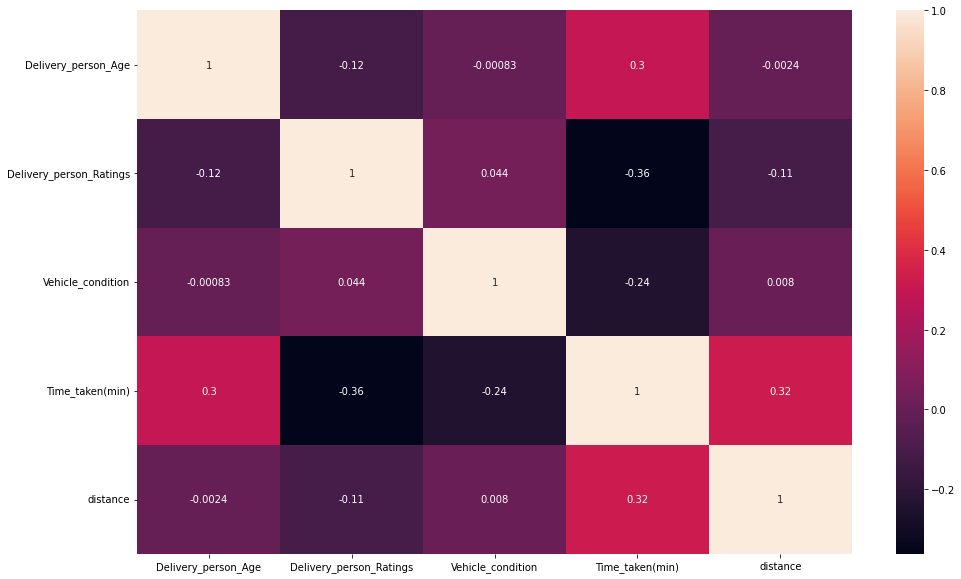

In [54]:
plt.figure(figsize=(16,10))
sns.heatmap(model_df[['Delivery_person_Age','Delivery_person_Ratings','Vehicle_condition','Time_taken(min)','distance']].corr(),annot=True)

### Onehot Encoding / Pandas dummies for categorical variables

In [163]:
dummies = {}
for ft in ['Type_of_order','Type_of_vehicle','City','Weatherconditions',
           'Road_traffic_density','Type_of_order','Type_of_vehicle','City','City_Name', 'Day']:
    dummies[ft] = pd.get_dummies(model_df[ft])

In [164]:
sum([dummies[dummy].shape[1] for dummy in dummies.keys()])

49

In [165]:
model_df.drop(dummies.keys(),axis=1,inplace=True)

In [166]:
for dummy in dummies:
    model_df = pd.concat([model_df,dummies[dummy]],axis=1)
    
model_df.head(3)

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,Time_taken(min),distance,Hour,Buffet,Drinks,Meal,Snack,...,Ranchi,Surat,Vadodara,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,37,4.9,2,24,3.02,11,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,34,4.5,2,33,20.14,19,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,23,4.4,0,26,1.55,08,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [167]:
X = model_df.drop('Time_taken(min)',axis=1)
y = model_df['Time_taken(min)']

In [168]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(X.iloc[:,:5])
X.iloc[:,:5] = scaled
X.head(3)

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,distance,Hour,Buffet,Drinks,Meal,Snack,electric_scooter,...,Ranchi,Surat,Vadodara,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1.282524,0.845853,1.229244,-1.202318,-1.343605,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.761930,-0.416083,1.229244,1.858369,0.326481,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,-1.146913,-0.731568,-1.217179,-1.465122,-1.969888,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [171]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [172]:
from sklearn.linear_model import LinearRegression
ln = LinearRegression()
ln.fit(X_train,y_train)

LinearRegression()

In [176]:
ln.score(X_test,y_test)

0.5495058438611506

In [177]:
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [182]:
xgbr.score(X_train,y_train)

0.8723736060294036

In [181]:
xgbr.score(X_test,y_test)

0.8194606088013936

In [183]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train,y_train)

Learning rate set to 0.070198
0:	learn: 8.8990477	total: 176ms	remaining: 2m 55s
1:	learn: 8.5109935	total: 193ms	remaining: 1m 36s
2:	learn: 8.1525409	total: 203ms	remaining: 1m 7s
3:	learn: 7.8306548	total: 214ms	remaining: 53.2s
4:	learn: 7.5392833	total: 218ms	remaining: 43.5s
5:	learn: 7.2806414	total: 224ms	remaining: 37s
6:	learn: 7.0573036	total: 229ms	remaining: 32.5s
7:	learn: 6.8420075	total: 235ms	remaining: 29.1s
8:	learn: 6.6566756	total: 241ms	remaining: 26.5s
9:	learn: 6.4454098	total: 245ms	remaining: 24.3s
10:	learn: 6.2811667	total: 249ms	remaining: 22.4s
11:	learn: 6.1037884	total: 254ms	remaining: 20.9s
12:	learn: 5.9614280	total: 261ms	remaining: 19.8s
13:	learn: 5.8354323	total: 265ms	remaining: 18.7s
14:	learn: 5.7119702	total: 270ms	remaining: 17.7s
15:	learn: 5.6025057	total: 276ms	remaining: 16.9s
16:	learn: 5.4991373	total: 281ms	remaining: 16.3s
17:	learn: 5.3827014	total: 287ms	remaining: 15.6s
18:	learn: 5.3000550	total: 291ms	remaining: 15s
19:	learn: 5.

189:	learn: 3.8694135	total: 1.26s	remaining: 5.39s
190:	learn: 3.8688897	total: 1.27s	remaining: 5.38s
191:	learn: 3.8672456	total: 1.27s	remaining: 5.37s
192:	learn: 3.8663689	total: 1.28s	remaining: 5.36s
193:	learn: 3.8656771	total: 1.29s	remaining: 5.34s
194:	learn: 3.8648593	total: 1.29s	remaining: 5.34s
195:	learn: 3.8642119	total: 1.3s	remaining: 5.32s
196:	learn: 3.8637280	total: 1.3s	remaining: 5.3s
197:	learn: 3.8625334	total: 1.31s	remaining: 5.29s
198:	learn: 3.8618097	total: 1.31s	remaining: 5.28s
199:	learn: 3.8613466	total: 1.31s	remaining: 5.26s
200:	learn: 3.8606946	total: 1.32s	remaining: 5.25s
201:	learn: 3.8591512	total: 1.32s	remaining: 5.23s
202:	learn: 3.8585675	total: 1.33s	remaining: 5.22s
203:	learn: 3.8579976	total: 1.33s	remaining: 5.2s
204:	learn: 3.8575008	total: 1.34s	remaining: 5.19s
205:	learn: 3.8569318	total: 1.34s	remaining: 5.17s
206:	learn: 3.8563365	total: 1.35s	remaining: 5.16s
207:	learn: 3.8547987	total: 1.35s	remaining: 5.15s
208:	learn: 3.85

348:	learn: 3.7638123	total: 2.16s	remaining: 4.02s
349:	learn: 3.7633631	total: 2.16s	remaining: 4.02s
350:	learn: 3.7628721	total: 2.17s	remaining: 4.01s
351:	learn: 3.7624792	total: 2.18s	remaining: 4.01s
352:	learn: 3.7619018	total: 2.18s	remaining: 4s
353:	learn: 3.7613055	total: 2.19s	remaining: 4s
354:	learn: 3.7610083	total: 2.19s	remaining: 3.99s
355:	learn: 3.7605002	total: 2.2s	remaining: 3.98s
356:	learn: 3.7600368	total: 2.2s	remaining: 3.97s
357:	learn: 3.7598127	total: 2.21s	remaining: 3.97s
358:	learn: 3.7593396	total: 2.22s	remaining: 3.96s
359:	learn: 3.7588600	total: 2.22s	remaining: 3.95s
360:	learn: 3.7583968	total: 2.23s	remaining: 3.95s
361:	learn: 3.7577365	total: 2.24s	remaining: 3.94s
362:	learn: 3.7572681	total: 2.24s	remaining: 3.94s
363:	learn: 3.7566850	total: 2.25s	remaining: 3.93s
364:	learn: 3.7561984	total: 2.25s	remaining: 3.92s
365:	learn: 3.7557655	total: 2.26s	remaining: 3.92s
366:	learn: 3.7552402	total: 2.27s	remaining: 3.91s
367:	learn: 3.754882

540:	learn: 3.6737823	total: 3.42s	remaining: 2.9s
541:	learn: 3.6735229	total: 3.42s	remaining: 2.89s
542:	learn: 3.6730761	total: 3.43s	remaining: 2.89s
543:	learn: 3.6727145	total: 3.44s	remaining: 2.88s
544:	learn: 3.6725089	total: 3.44s	remaining: 2.87s
545:	learn: 3.6720598	total: 3.45s	remaining: 2.87s
546:	learn: 3.6718619	total: 3.45s	remaining: 2.86s
547:	learn: 3.6714485	total: 3.46s	remaining: 2.85s
548:	learn: 3.6710059	total: 3.46s	remaining: 2.84s
549:	learn: 3.6707373	total: 3.47s	remaining: 2.84s
550:	learn: 3.6702792	total: 3.47s	remaining: 2.83s
551:	learn: 3.6698771	total: 3.48s	remaining: 2.82s
552:	learn: 3.6696102	total: 3.48s	remaining: 2.81s
553:	learn: 3.6688426	total: 3.48s	remaining: 2.81s
554:	learn: 3.6685155	total: 3.49s	remaining: 2.8s
555:	learn: 3.6680597	total: 3.49s	remaining: 2.79s
556:	learn: 3.6677201	total: 3.5s	remaining: 2.78s
557:	learn: 3.6672114	total: 3.5s	remaining: 2.77s
558:	learn: 3.6667536	total: 3.51s	remaining: 2.77s
559:	learn: 3.66

702:	learn: 3.6111269	total: 4.49s	remaining: 1.9s
703:	learn: 3.6108946	total: 4.5s	remaining: 1.89s
704:	learn: 3.6102451	total: 4.5s	remaining: 1.88s
705:	learn: 3.6100186	total: 4.51s	remaining: 1.88s
706:	learn: 3.6097770	total: 4.53s	remaining: 1.88s
707:	learn: 3.6094301	total: 4.53s	remaining: 1.87s
708:	learn: 3.6091196	total: 4.54s	remaining: 1.86s
709:	learn: 3.6087283	total: 4.55s	remaining: 1.86s
710:	learn: 3.6083337	total: 4.55s	remaining: 1.85s
711:	learn: 3.6080464	total: 4.56s	remaining: 1.84s
712:	learn: 3.6075961	total: 4.56s	remaining: 1.84s
713:	learn: 3.6071007	total: 4.57s	remaining: 1.83s
714:	learn: 3.6068491	total: 4.57s	remaining: 1.82s
715:	learn: 3.6066068	total: 4.58s	remaining: 1.82s
716:	learn: 3.6061892	total: 4.58s	remaining: 1.81s
717:	learn: 3.6057216	total: 4.59s	remaining: 1.8s
718:	learn: 3.6055626	total: 4.6s	remaining: 1.8s
719:	learn: 3.6054210	total: 4.61s	remaining: 1.79s
720:	learn: 3.6050838	total: 4.61s	remaining: 1.78s
721:	learn: 3.6047

873:	learn: 3.5494019	total: 5.56s	remaining: 801ms
874:	learn: 3.5491256	total: 5.56s	remaining: 795ms
875:	learn: 3.5487113	total: 5.57s	remaining: 789ms
876:	learn: 3.5482556	total: 5.58s	remaining: 783ms
877:	learn: 3.5480821	total: 5.59s	remaining: 777ms
878:	learn: 3.5478052	total: 5.6s	remaining: 771ms
879:	learn: 3.5473805	total: 5.6s	remaining: 764ms
880:	learn: 3.5470663	total: 5.61s	remaining: 758ms
881:	learn: 3.5465863	total: 5.62s	remaining: 752ms
882:	learn: 3.5462482	total: 5.62s	remaining: 745ms
883:	learn: 3.5460349	total: 5.63s	remaining: 739ms
884:	learn: 3.5457078	total: 5.64s	remaining: 733ms
885:	learn: 3.5452412	total: 5.64s	remaining: 726ms
886:	learn: 3.5450049	total: 5.65s	remaining: 720ms
887:	learn: 3.5447109	total: 5.66s	remaining: 714ms
888:	learn: 3.5444398	total: 5.67s	remaining: 707ms
889:	learn: 3.5440006	total: 5.67s	remaining: 701ms
890:	learn: 3.5437443	total: 5.68s	remaining: 695ms
891:	learn: 3.5435504	total: 5.69s	remaining: 688ms
892:	learn: 3.

In [184]:
cat.score(X_train,y_train)

0.8587852445806589

In [185]:
cat.score(X_test,y_test)

0.8250424472030405